# Algoritmo PCA

El algoritmo PCA (Análisis de Componentes Principales) permite encontrar una representación de baja dimensionalidad $\mathbf{y_i}$ que explica la varianza de los datos originales $\mathbf{x_i}$. 

\begin{align*}
\mathbf{y_i}=U^T (\mathbf{x_i}-\mu)\\
\tilde{\mathbf{x_i}}=U \mathbf{y_i} +\mu
\end{align*}

In [ ]:
using LinearAlgebra; 
using MultivariateStats;
using Statistics;

X=[ 7  4  3;
    4  1  8; 
    6  3  5;
    8  6  1;
    8  5  7;
    7  2  9;
    5  3  3;
    9  5  8;
    7  4  5;
    8  2  2];
μ=mean!([1. 1. 1.],X)
X_m=(X.-μ)
M = fit(PCA, transpose(X_m),maxoutdim=3)
Yte = transform(M, transpose(X_m))
X_r=transpose(reconstruct(M, Yte)).+μ
E=norm(X-X_r)

In [ ]:
M

In [ ]:
typeof(X_m)

In [ ]:
values,vectors=eigen(cov(X_m));

In [ ]:
U=[vectors[:,3] vectors[:,2]]
V=sort(values[2:3],rev=true)
U_s=sqrt.(V)'.*U

In [ ]:
U

In [ ]:
M.prinvars

In [ ]:
V

In [ ]:
M.proj

In [ ]:
imp=V./sum(V)
print("Proportion explained : $imp")

In [ ]:
Y_t=transpose(U)*transpose(X_m)
X_r2=transpose(U*Y_t).+μ

In [ ]:
transpose(U)

In [ ]:
using Plots;

plot(sort(values,rev=true))

In [ ]:
norm(X-X_r)

# EigenFaces

En el caso del reconocimiento facial, el algoritmo Eigenfaces utiliza esta representación de baja dimensionalidad para comparar caras nuevas (no utilizadas para ajustar los valores y vectores propios). Sin embargo, una de los problemas al utlizar esta técnica es determinar la dimensionalidad \emph{intrinsica} de los datos. Esto quiere decir que el número de componentes principales es desconocido y debe determinarse mediante un compromiso entre el error de reconstrucción $E=\sum_i^n (\mathbf{x_i}-\tilde{\mathbf{x_i}})^2$ y la capacidad de comprimir y explicar los datos.

https://bio322.epfl.ch/notebooks/pca.html

In [ ]:
using Images,Colors
using ImageTransformations

path="eigenvalue_pics/"
dim=64

function images_to_mat(pathlist,dim,data_type)
    mat=zeros(data_type,length(pathlist),dim*dim)
    for (index,images) in enumerate(pathlist)
        img=load(images)
        img_g=Gray.(img)
        img_g=imresize(img_g,dim,dim)
        img_g=data_type.(img_g)
        img_g=reshape(img_g,(1,dim*dim))
        mat[index,:]=img_g
    end 
    return mat
end



In [ ]:
pathlist=[]
names=[]
for d in readdir(path)
    for f in readdir(path*d)
        file_path=path*d*"/"*f
        push!(pathlist,file_path)
        push!(names,d)
    end 
end 

In [ ]:
using LinearAlgebra; 
using MultivariateStats;
using Statistics;

my_type=Float64
mat=images_to_mat(pathlist,dim,my_type)
mean_face=mean!(transpose(ones(dim*dim)),mat)
centered_mat=mat.-my_type.(mean_face);

In [ ]:
values,vectors=eigen(cov(centered_mat));

In [ ]:
typeof(vectors)

In [ ]:
sorted_values=sort(values,rev=true);

In [ ]:
length(sorted_values)

In [ ]:
using Plots;

sorted_values=sorted_values./sum(sorted_values)
plot(sorted_values[1:100],lw=3)

In [ ]:
size(vectors)

In [ ]:
num_components=25

In [ ]:
eigenfaces=vectors[:,dim*dim:-1:(dim*dim-num_components+1)];

In [ ]:
size(eigenfaces)

In [ ]:
P=transpose(eigenfaces)*transpose(centered_mat);

In [ ]:
size(mat)

In [ ]:
size(P)

# Error de predicción

In [ ]:
img=load("test.jpg")
img_g=Gray.(img)
img_g=imresize(img_g,dim,dim)

In [ ]:
x_i=reshape(my_type.(img_g),(1,dim*dim))-mean_face
P_i=transpose(eigenfaces)*transpose(x_i);

In [ ]:
size(eigenfaces)

In [ ]:
eigenfaces

In [ ]:
dist=[]
for i in 1:22
    push!(dist,norm(P[:,i]-P_i))
end
pred=names[argmin(dist)]
print("La persona es : $pred")

# Cuantización

In [ ]:
function quantization(x, s, z, alpha_q, beta_q)
    x_q=((1 / s) * x).+z
    x_q = round.(x_q)
    x_q = clamp.(x_q, alpha_q, beta_q)
    return x_q
end

function quantization_int8(x, s, z)
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = Int8.(x_q)
    return x_q
end

function dequantization(x_q, s, z)
    # x_q - z might go outside the quantization range.
    x_q = Float32.(x_q)
    x = s * (x_q .- z)
    x = Float32.(x)
    return x
end

function generate_quantization_constants(alpha, beta, alpha_q, beta_q)
    # Affine quantization mapping
    s = (beta - alpha) / (beta_q - alpha_q)
    z = ((beta * alpha_q - alpha * beta_q) / (beta - alpha))
    return s, z
end

In [ ]:
b=8
r=randn(10);

alpha=minimum(r)
beta=maximum(r)
alpha_q = -2^(b - 1)
beta_q = 2^(b - 1) - 1

s,z=generate_quantization_constants(alpha,beta,alpha_q,beta_q)
q_r=quantization(r,s,z,alpha_q,beta_q);

In [ ]:
q_r

In [ ]:
for (i,j,k) in zip( dequantization(q_r,s,z),r,Int8.(round.(r)))
    println("valor original : $j, valor cuantizado $i, valor truncado : $k")
end

In [ ]:
error=norm(r-Int8.(round.(r)))

In [ ]:
error=norm(r-dequantization(q_r,s,z))

In [ ]:
r=eigenfaces[:,1]
alpha=minimum(r)
beta=maximum(r)
alpha_q = -2^(b - 1)
beta_q = 2^(b - 1) - 1

s,z=generate_quantization_constants(alpha,beta,alpha_q,beta_q)
q_r=quantization(r,s,z,alpha_q,beta_q);
q_r=Int8.(q_r)

In [ ]:
q_r

In [ ]:
error=norm(r-dequantization(q_r,s,z))

# Error de Reconstrucción

In [ ]:
R=transpose(eigenfaces*P).+mean_face

In [ ]:
R_i=transpose(eigenfaces*P_i).+mean_face

In [ ]:
norm(mat-R)

In [ ]:
Gray.((reshape(mean_face,(dim,dim))))

In [ ]:
Gray.((reshape(R_i,(dim,dim))))

In [8]:
using OpenML, DataFrames
faces = OpenML.load(41083) |> DataFrame


Row,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,⋯
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,⋯
1,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.68595,0.702479,0.698347,0.694215,0.698347,0.690083,0.694215,0.690083,0.698347,0.702479,0.702479,0.698347,0.706612,0.710744,0.719008,0.727273,0.756198,0.772727,0.77686,0.77686,0.756198,0.760331,0.780992,0.760331,0.768595,0.756198,0.739669,0.743802,0.739669,0.743802,0.719008,0.719008,0.714876,0.719008,0.719008,0.72314,0.727273,0.735537,0.714876,0.72314,0.719008,0.714876,0.710744,0.702479,0.706612,0.698347,0.677686,0.657025,0.632231,0.566116,0.524793,0.446281,0.371901,0.330578,0.305785,0.342975,0.404959,0.438017,0.471074,0.553719,0.623967,0.669422,0.68595,0.690083,0.68595,0.694215,0.690083,0.698347,0.702479,0.698347,0.694215,0.706612,0.710744,0.710744,0.714876,0.710744,0.702479,0.719008,0.727273,0.735537,0.760331,0.77686,0.785124,0.780992,0.77686,0.772727,0.789256,0.785124,0.772727,0.764463,0.747934,⋯
2,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,0.710744,0.698347,0.702479,0.706612,0.706612,0.714876,0.714876,0.706612,0.698347,0.714876,0.698347,0.72314,0.731405,0.743802,0.756198,0.772727,0.768595,0.785124,0.764463,0.756198,0.731405,0.743802,0.735537,0.719008,0.706612,0.714876,0.719008,0.710744,0.710744,0.706612,0.702479,0.702479,0.702479,0.690083,0.681818,0.690083,0.68595,0.669422,0.677686,0.665289,0.652893,0.657025,0.640496,0.619835,0.615702,0.578512,0.5,0.359504,0.31405,0.214876,0.194215,0.190083,0.18595,0.18595,0.446281,0.483471,0.520661,0.566116,0.619835,0.665289,0.706612,0.710744,0.719008,0.714876,0.706612,0.698347,0.706612,0.702479,0.702479,0.694215,0.710744,0.710744,0.714876,0.72314,0.710744,0.727273,0.739669,0.743802,0.764463,0.756198,0.768595,0.768595,0.772727,0.752066,0.739669,0.735537,0.72314,0.714876,0.710744,0.690083,⋯
3,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.68595,0.702479,0.698347,0.702479,0.706612,0.706612,0.714876,0.710744,0.706612,0.706612,0.706612,0.72314,0.719008,0.719008,0.710744,0.710744,0.752066,0.756198,0.764463,0.785124,0.797521,0.838843,0.826446,0.842975,0.847107,0.830578,0.818182,0.793388,0.768595,0.760331,0.756198,0.739669,0.710744,0.719008,0.702479,0.702479,0.702479,0.706612,0.706612,0.719008,0.706612,0.710744,0.710744,0.706612,0.710744,0.702479,0.694215,0.690083,0.669422,0.636364,0.636364,0.599174,0.545455,0.475207,0.400826,0.355372,0.309917,0.309917,0.396694,0.479339,0.561983,

In [ ]:
x = Matrix(faces[:, 1:4096])  # datos numéricos (imágenes)
y = faces[:, 4097] 

In [9]:
size(x)  # debería dar (n_imagenes, 4096)


(400, 4096)

In [10]:
size(y)  # debería dar (n_imagenes,)

(400,)

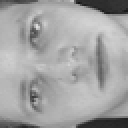

In [2]:
using Images, Colors, ImageShow
    img = reshape(X[1, :], 64, 64)  # vuelve a forma 64x64
    Gray.(img)                  # asegúrate de mostrarla en escala de grises



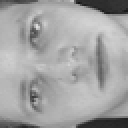

Redimensionando desde 64x64 a 64x64...
Imagen original mostrada (64x64)

--- PCA con 5 componentes ---
size(W) = (4096, 5)
Reconstrucción con 5 componentes completada.

--- PCA con 10 componentes ---
size(W) = (4096, 10)
Reconstrucción con 10 componentes completada.

--- PCA con 20 componentes ---
size(W) = (4096, 20)
Reconstrucción con 20 componentes completada.

--- PCA con 50 componentes ---
size(W) = (4096, 50)
Reconstrucción con 50 componentes completada.


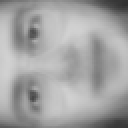

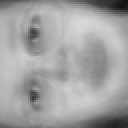

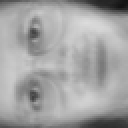

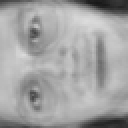

In [3]:
using OpenML, DataFrames, Statistics, MultivariateStats, LinearAlgebra
using Images, ImageTransformations, ImageShow, Colors

# -------------------------------------------------------
# 1) Cargar y preparar los datos
# -------------------------------------------------------
faces = OpenML.load(41083) |> DataFrame
X = Float64.(Matrix(faces[:, 1:end-1]))
y = faces[:, end]

# -------------------------------------------------------
# 2) Redimensionar imágenes a 64x64
# -------------------------------------------------------
orig_dim = Int(sqrt(size(X, 2)))
target_dim = 64
n = size(X, 1)
println("Redimensionando desde $(orig_dim)x$(orig_dim) a $(target_dim)x$(target_dim)...")

X_resized = zeros(Float64, n, target_dim * target_dim)
for i in 1:n
    img = reshape(X[i, :], orig_dim, orig_dim)
    img_resized = imresize(Gray.(img), (target_dim, target_dim))
    X_resized[i, :] = Float64.(vec(img_resized))
end

# -------------------------------------------------------
# 3) Centrar datos
# -------------------------------------------------------
mu = mean(X_resized, dims=1)
X_centered = X_resized .- mu
mu_vec = vec(mu)

# -------------------------------------------------------
# 4) Seleccionar imagen para reconstruir
# -------------------------------------------------------
sample_index = 1
original = reshape(X_resized[sample_index, :], target_dim, target_dim)
display(Gray.(original))
println("Imagen original mostrada (64x64)")

# -------------------------------------------------------
# 5) PCA manual + reconstrucción
# -------------------------------------------------------
for ncomp in (5, 10, 20, 50)
    println("\n--- PCA con $ncomp componentes ---")

    # PCA sobre las columnas (variables = píxeles)
    pca_model = fit(PCA, X_centered'; maxoutdim=ncomp)  # ¡transpuesta aquí!

    # Obtener matriz de proyección: ahora será p×k (4096×ncomp)
    W = projection(pca_model)
    println("size(W) = ", size(W))

    # Vector centrado de la imagen elegida
    x_c = vec(X_centered[sample_index, :])   # 4096×1

    # Proyección y reconstrucción
    z = W' * x_c          # (k×p)*(p×1) → k×1
    recon_c = W * z       # (p×k)*(k×1) → p×1
    recon = recon_c .+ mu_vec

    # Mostrar imagen reconstruida
    recon_img = reshape(recon, target_dim, target_dim)
    display(Gray.(recon_img))
    println("Reconstrucción con $ncomp componentes completada.")
end
